In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

In [2]:
# Downloading dataset
!wget https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/car/Leinhardt.csv

--2021-05-01 19:05:45--  https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/car/Leinhardt.csv
Resolving forge.scilab.org (forge.scilab.org)... 109.7.104.55
Connecting to forge.scilab.org (forge.scilab.org)|109.7.104.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3547 (3,5K) [text/csv]
Saving to: ‘Leinhardt.csv.1’

Leinhardt.csv.1     100%[===================>]   3,46K  --.-KB/s    in 0s      

2021-05-01 19:05:47 (72,8 MB/s) - ‘Leinhardt.csv.1’ saved [3547/3547]



In [3]:
# Read dataset - Infant mortality
lein = pd.read_csv('Leinhardt.csv')
# Checking dataframe
print("The shape of the dataset is: {}".format(lein.shape))
lein.head()

The shape of the dataset is: (105, 5)


Unnamed: 0  income  infant    region oil
0  Australia    3426    26.7      Asia  no
1    Austria    3350    23.7    Europe  no
2    Belgium    3346    17.0    Europe  no
3     Canada    4751    16.8  Americas  no
4    Denmark    5029    13.5    Europe  no

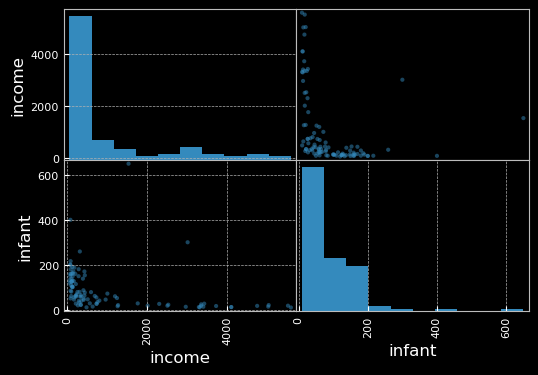

In [4]:
# Dropping NaN
lein = lein.dropna()
# Showing scatter matrix
pd.plotting.scatter_matrix(lein, alpha=0.5)
plt.show()

Previously, we worked with infant mortality and income on the logarithmic scale. 

In [5]:
# Changing the domain of the variable
log_income = np.array(np.log(lein['income'])).reshape(-1,)
log_infant = np.array(np.log(lein['infant'])).reshape(-1,)
# Mapping region to integers
region = lein['region'].astype("category").cat.codes.to_numpy()
oil = lein['oil'].astype("category").cat.codes.to_numpy()

In [6]:
# Assigning variables
X = np.vstack((log_income, region, oil)).T
Y = log_infant

print('The shape of X is {}'.format(X.shape))
print('The shape of Y is {}'.format(Y.shape))

n_regions = region.max() + 1
print('The number of regios are: {}'.format(n_regions))

The shape of X is (101, 3)
The shape of Y is (101,)
The number of regios are: 4


### Model

This can be seen below:

$y_{i} | r_i, x_i, \alpha, \beta, \sigma^2  \stackrel{ind}{\sim} \mathcal{N}(\alpha_{r_i} + \beta_1 X_{1,i} + \beta_2 X_{2, i}, \sigma^2)$ 

$i = 1,...,n$

$r_i \in {1,...R}$

$\alpha_r | \mu, \tau \stackrel{iid}{\sim} \mathcal{N}(\mu, \tau^2) \,  r = 1 , ... , R$

$\sigma^2 \sim InvGamma(\frac{5}{2}, \frac{5 \times 10}{2})$

$\beta_1 \sim \mathcal{N}(0, 10^6)$

$\beta_2 \sim \mathcal{N}(0, 10^6)$

$\mu \sim \mathcal{N}(0, 10^6)$

$\tau \sim InvGamma(\frac{1}{2}, \frac{1 \times 10}{2})$

In [7]:
with pm.Model() as lr:
    ###  Definen priors of parameters

    # Third level of parameters
    mu = pm.Normal('mu', mu = 0, sigma = 1e6) # Mu parameter 
    tau = pm.InverseGamma('tau', alpha = 1.0 / 2.0, beta = (1 * 10.0) / 2.0) # Tau parameter

    # Second level of parameters
    a = pm.Normal('alpha', mu = mu, sigma = tau, shape = n_regions)
    b_1 = pm.Normal('b_1', mu = 0, sigma = 1e6) # Parameter for Log income
    b_2 = pm.Normal('b_2', mu = 0, sigma = 1e6) # Parameter for oil
    sigma_2 = pm.InverseGamma('sigma_2', alpha = 5.0 / 2.0, beta = (5 * 10.0) / 2.0)

    # First level of parameters 
    x_ = pm.Data('features', X) # Data container, can be changed
    region_var = pm.Data('regions', X[:, 1].astype(int)) # Regions as int

    # Column 0 -> Log income
    # Column 1 -> region
    # Column 2 -> oil

    expect_y = a[region_var] + b_1 * x_[:, 0] + b_2 * x_[:, 2]

    # Likelihood
    obs = pm.Normal('likelihood', mu = expect_y, sigma = sigma_2, observed = Y)

In [8]:
with lr:
    # Use MCMC to sample 10000 samples
    trace = pm.sample(6000, tune = 3000, cores=4, init='adapt_diag')
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_2, b_2, b_1, alpha, tau, mu]


Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.


### MCMC convergence diagnostic

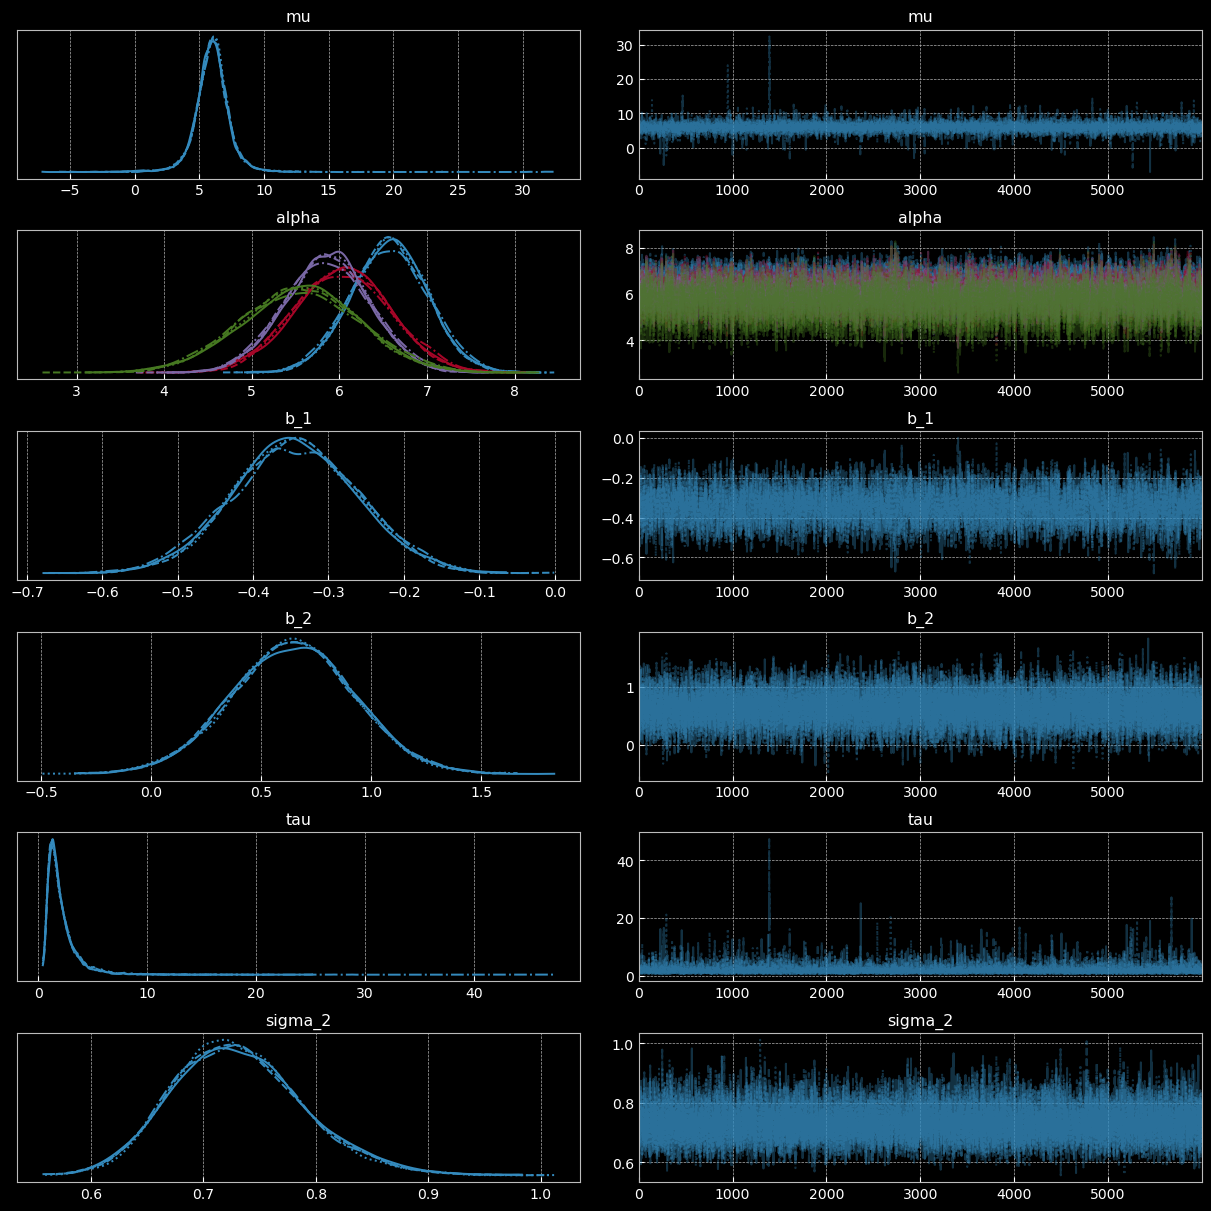

In [9]:
# Plotting posterior distributions
az.plot_trace(trace)
plt.show()

In [10]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu        6.002  1.424   3.414    8.421      0.018    0.015    5978.0   
alpha[0]  6.566  0.436   5.728    7.369      0.006    0.004    5011.0   
alpha[1]  6.027  0.549   5.018    7.086      0.008    0.005    5032.0   
alpha[2]  5.860  0.488   4.905    6.743      0.007    0.005    4995.0   
alpha[3]  5.554  0.673   4.281    6.808      0.010    0.007    4941.0   
b_1      -0.344  0.083  -0.495   -0.183      0.001    0.001    4804.0   
b_2       0.644  0.280   0.102    1.154      0.002    0.002   16166.0   
tau       2.137  1.580   0.512    4.570      0.019    0.014    6630.0   
sigma_2   0.731  0.058   0.628    0.845      0.000    0.000   15587.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
mu         4457.0    7793.0    7962.0    1.0  
alpha[0]   4998.0    5008.0    7686.0    1.0  
alpha[1]   5024.0    5031.0    8073.0    1.0  
alpha[2]   4987.0    4994.0    7937.0    1.0  
alpha[3]   4923.0    4942.0    7298.0    1.0  
b_1        4778.0    4805.0    6933.0    1.0  
b_2       15422.0   16162.0   14647.0    1.0  
tau        6630.0    9177.0    9054.0    1.0  
sigma_2   15485.0   15614.0   13900.0    1.0

In this particular model, the intercepts do not have a real interpretation because they correspond to the mean response for a country that does not produce oil and has $\$0$ log-income per capita (which is $\$1$ income per capita). We can interpret $\mu$ as the overall mean intercept and $τ$ as the standard deviation of intercepts across regions.

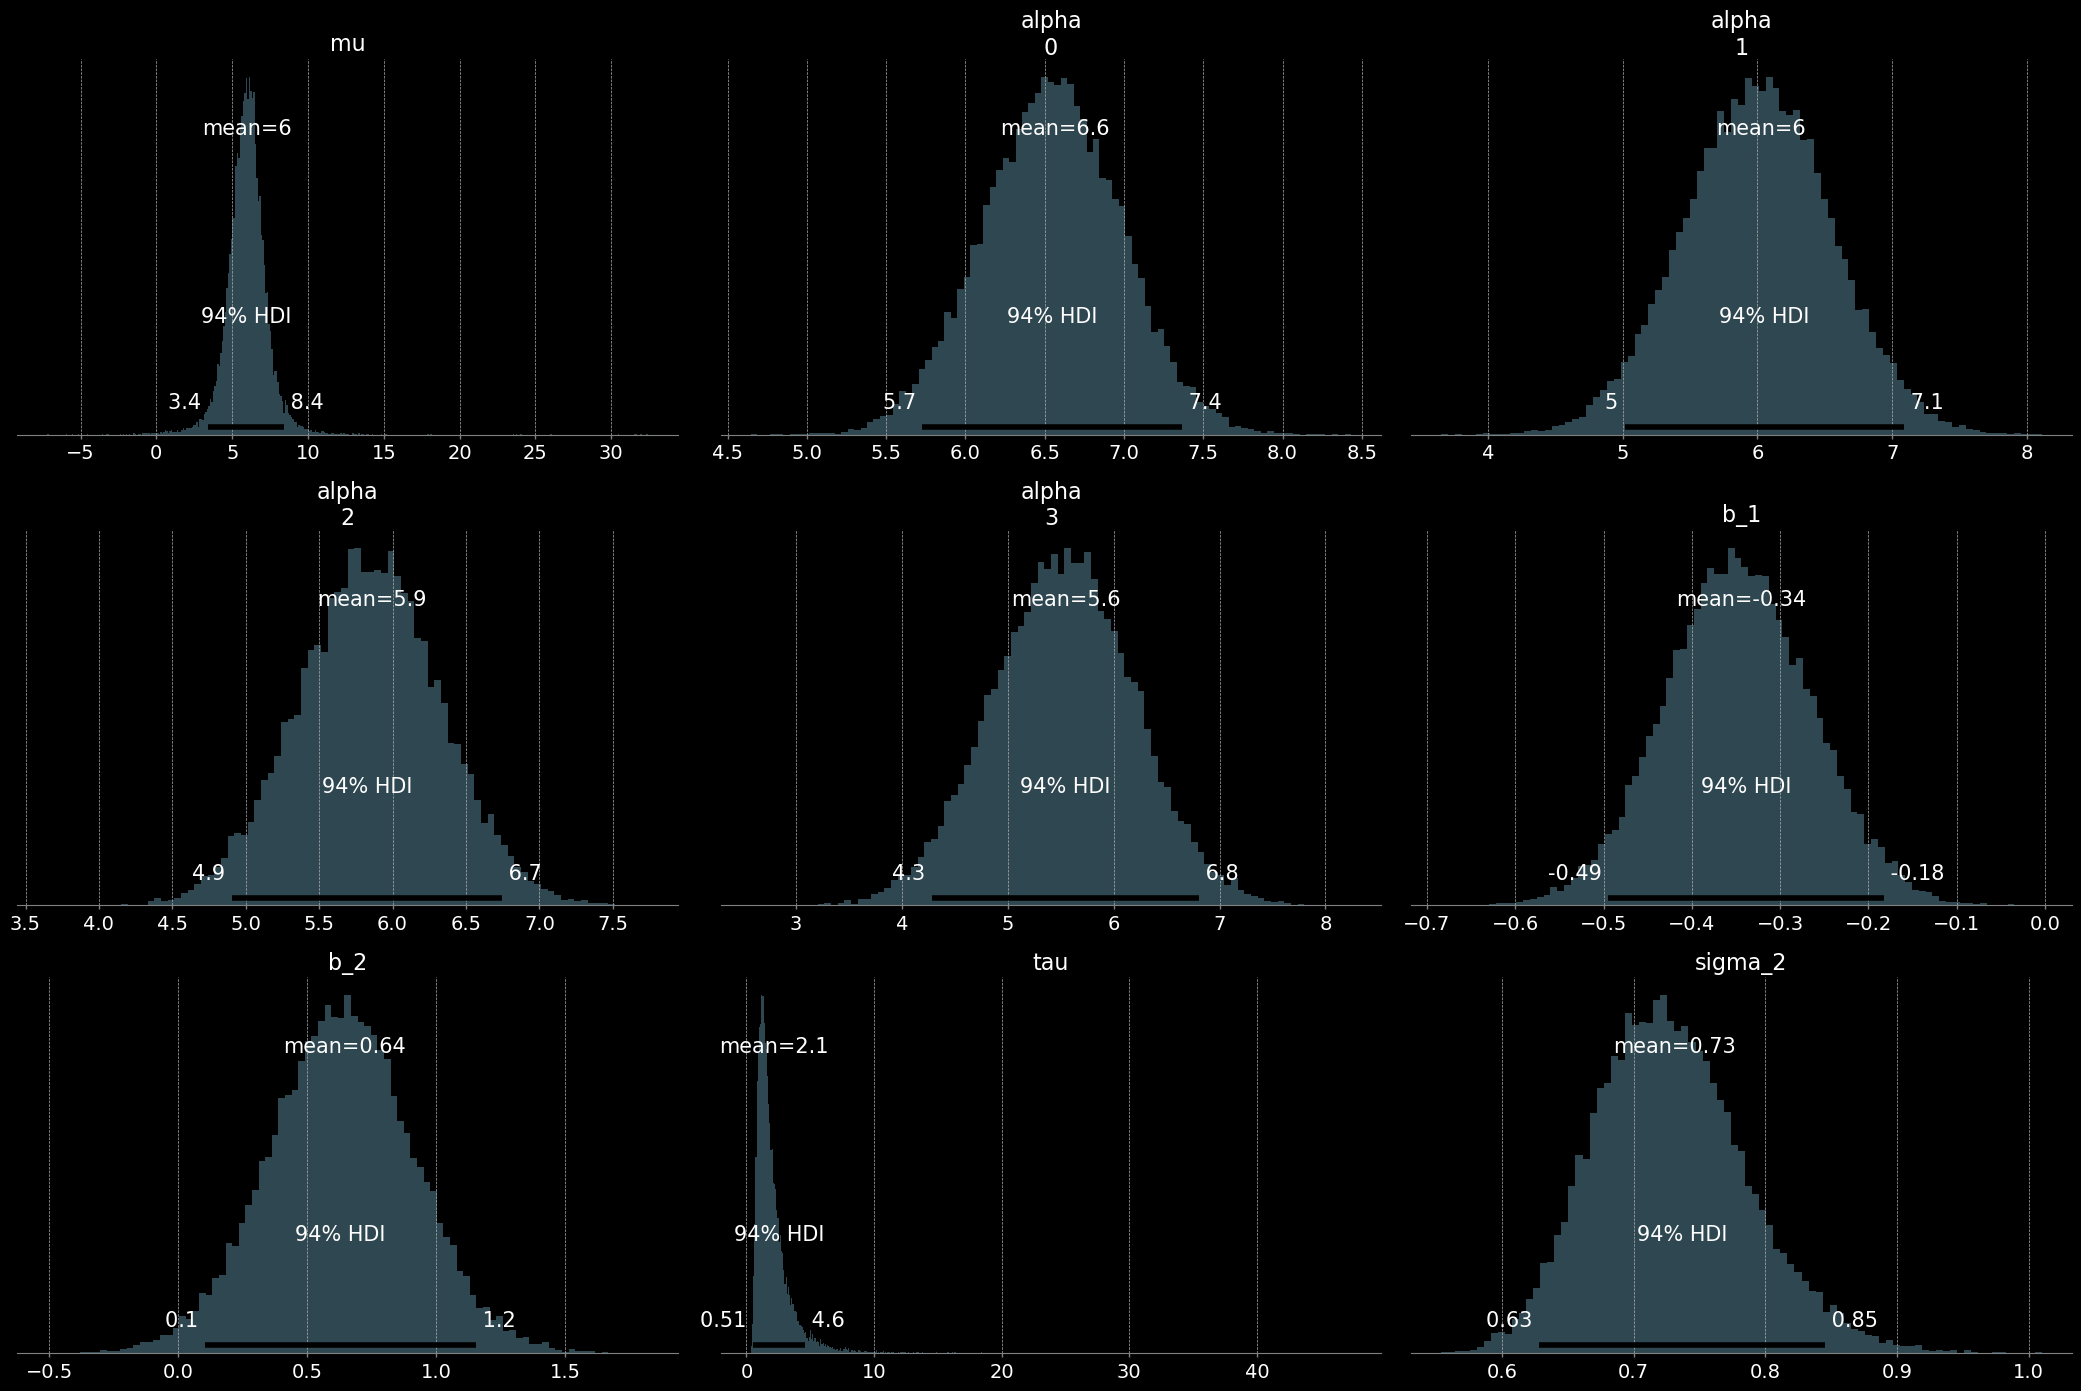

In [11]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

### Other models

We have not investigated adding interaction terms, which might be appropriate. We only considered adding hierarchy on the intercepts, but in reality nothing prevents us from doing the same for other terms in the model, such as the coefficients for income and oil. We could try any or all of these alternatives and see how the DIC changes for those models.
